In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision import models
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn.functional as F

In [2]:
from src import display
from src import data_transformer as dt

In [3]:
img_path = "data/VOCdevkit/VOC2012/JPEGImages/"
seed = 42
target_size = 224

In [4]:
train_json_path = "data/pascal_train2012.json"

In [5]:
id_cat, train_list = dt.load_pascal(train_json_path)

In [6]:
train_list = dt.rescale_bounding_boxes(train_list, target_size)
train_list = dt.convert_to_center(train_list)

In [7]:
example = train_list[0]
example

['2008_000008.jpg',
 ['horse', 'person'],
 [12, 14],
 [[117.0, 128.5, 188, 169], [99.5, 53.5, 59, 63]]]

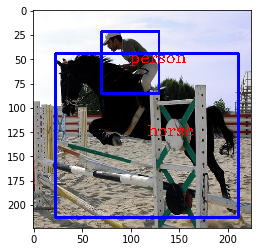

In [8]:
img_str = img_path + example[0]
img = display.read_img(img_str, target_size)

img = display.draw_boxes(img, example[3])
img = display.draw_text(img, example[1], example[3])
plt.imshow(img)
plt.show()

In [9]:
anchor_grid = [4, 2, 1] # Number of grid-elements per dimension
anchor_zooms = [0.7, 1.0, 1.3] # How much bigger/smaller each default box will be (percentage)
anchor_ratios = [(1.0, 1.0), (1.0, 0.5), (0.5, 1.0)] # Ratio between (width, height)

anchor_scales = [(anc*h, anc*w) for anc in anchor_zooms for (h,w) in anchor_ratios]
anchor_offsets = [1/(2*o) for o in anchor_grid]
num_boxes = len(anchor_scales)

In [10]:
anchor_x = [np.repeat(np.linspace(ao, 1-ao, ag), ag) for (ao, ag) in zip(anchor_offsets, anchor_grid)]
anchor_x = np.concatenate(anchor_x)

anchor_y = [np.tile(np.linspace(ao, 1-ao, ag), ag) for ao,ag in zip(anchor_offsets, anchor_grid)]
anchor_y = np.concatenate(anchor_y)

anchor_centers = np.repeat(np.stack([anchor_x, anchor_y], axis=1), num_boxes, axis=0)

In [11]:
anchor_sizes  = [np.array([[w/ag, h/ag] for _ in range(ag**2) for w, h in anchor_scales])
                 for ag in anchor_grid]
anchor_sizes = np.concatenate(anchor_sizes)

anchors = np.concatenate([anchor_centers, anchor_sizes], axis=1)

In [12]:
anchors = torch.from_numpy(anchors).float()

In [13]:
def center_2_hw(box):
    """
    Converting (bx, by, w, h) to (x1, y1, x2, y2)
    """
    
    return torch.cat(
        [box[:, 0:1] - box[:, 2:3]/2,
         box[:, 1:2] - box[:, 3:4]/2,
         box[:, 0:1] + box[:, 2:3]/2,
         box[:, 1:2] + box[:, 3:4]/2
         ], dim=1)

def intersect(anchors, ground_truth):
    max_xy = torch.min(anchors[:, None, 2:], ground_truth[None, :, 2:])
    min_xy = torch.max(anchors[:, None, :2], ground_truth[None, :, :2])
    inter = torch.clamp((max_xy - min_xy), min=0)
    return inter[:, :, 0] * inter[:, :, 1]

def box_area(box): 
    area = (box[:, 2] - box[:, 0]) * (box[:, 3] - box[:, 1])
    return area

def jaccard(anchors, ground_truth):
    """
    Box with shape bx, by, w, h
    """
    
    temp_anchors, temp_ground_truth = center_2_hw(anchors), center_2_hw(ground_truth)
    intersection = intersect(temp_anchors, temp_ground_truth)
    union = box_area(temp_anchors).unsqueeze(1) + box_area(temp_ground_truth).unsqueeze(0) - intersection
    return intersection / union

In [14]:
device = "cuda"

In [15]:
max_overlaps = []
ground_truths = []
classes = []

for item in train_list:
    gt = np.vstack(item[3])
    gt = torch.from_numpy(gt).float() / target_size
    ground_truths.append(gt[None, :, :].to(device))
    
    jaccard_tensor = jaccard(anchors, gt)
    _, max_overlap = jaccard_tensor.max(0)
    
    max_overlaps.append(max_overlap.to(device))
    
    # NOTE: ADDING +1 since first element should be bakcground checks, need to be fixed later
    classes.append(torch.from_numpy(np.array(item[2])[None, :]).to(device) + 1)

In [16]:
def flatten_conv(x, num_boxes):
    samples, channels, _, _ = x.size()
    x = x.permute(0, 2, 3, 1).contiguous()
    return x.view(samples, -1, int(channels/num_boxes))

class StandardConv(nn.Module):
    def __init__(self, in_channels, out_channels, stride=2, drop_rate=0.0):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn = nn.BatchNorm2d(out_channels)
        self.drop = nn.Droupout(drop_rate)

    def forward(self, x):
        x = self.conv(x)
        x = F.relu(x)
        #x = self.bn(x)
        #x = self.drop(x)
        return x        

class OutputConv(nn.Module):
    def __init__(self, in_channels, num_boxes):
        super().__init__()
        self.num_boxes = num_boxes
        self.conv_1 = nn.Conv2d(in_channels, (len(id_cat)+1)*num_boxes, kernel_size=3, padding=1)
        self.conv_2 = nn.Conv2d(in_channels, 4*num_boxes, kernel_size=3, padding=1)

    def forward(self, x):
        # [class predictions, box coordinates]
        return [flatten_conv(self.conv_1(x), self.num_boxes), 
                flatten_conv(self.conv_2(x), self.num_boxes)]

class Model(nn.Module):
    def __init__(self, num_boxes):
        super().__init__()
        
        pretrained_model = list(models.vgg16(pretrained='imagenet').children())[:-1]
        self.pretrained_model = nn.Sequential(*pretrained_model)
        
        self.std_conv_1 = StandardConv(512, 256, stride=1)
        self.std_conv_2 = StandardConv(256, 256)
        self.std_conv_3 = StandardConv(256, 256)
        self.std_conv_4 = StandardConv(256, 256)
        
        self.out_conv_1 = OutputConv(256, num_boxes)
        self.out_conv_2 = OutputConv(256, num_boxes)
        self.out_conv_3 = OutputConv(256, num_boxes)
                                       
    def forward(self, x):
        x = self.pretrained_model(x)
        x = self.std_conv_1(x)
        x = self.std_conv_2(x)
        output_class_1, output_bb_1 = self.out_conv_1(x)
        
        x = self.std_conv_3(x)
        output_class_2, output_bb_2 = self.out_conv_2(x)
        
        x = self.std_conv_4(x)
        output_class_3, output_bb_3 = self.out_conv_3(x)
        
        # Class, bounding box
        return [torch.cat([output_class_1, output_class_2, output_class_3], dim=1),
                torch.cat([output_bb_1, output_bb_2, output_bb_3], dim=1)
                ]
    
    def change_freezing(self, mode=False):
        for param in self.pretrained_model.parameters():
            param.requires_grad = mode

In [17]:
class PascalData(Dataset):
    def __init__(self, data_list, ground_truths, classes, max_overlaps, target_size=target_size, path=img_path):
        self.target_size = target_size
        self.path = path
        
        self.file_list = [i[0] for i in data_list]
        self.ground_truths = ground_truths
        self.classes = classes
        self.max_overlaps = max_overlaps
            
        self.mean = np.array([0.485, 0.456, 0.406]).reshape((1,1,3))
        self.std = np.array([0.229, 0.224, 0.225]).reshape((1,1,3))
    
    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self, idx):
        img_str = self.path + self.file_list[idx]
        
        img = display.read_img(img_str, self.target_size)
        img = img / 255.0
        img = (img - self.mean) / self.std
        img = img.transpose((2, 0, 1))
        img = torch.from_numpy(img).float().to(device)
        
        return (img, self.ground_truths[idx], self.classes[idx], self.max_overlaps[idx])
    
def collate_fn(batch):
    """
    Writing custom collector function since the Dataset class returns both tensors and lists.
    """
    
    x = [b[0] for b in batch]
    x = torch.stack(x, dim=0)
    gt = [b[1] for b in batch]
    c = [b[2] for b in batch]
    max_overlap = [b[3] for b in batch]
    return (x, gt, c, max_overlap)

In [18]:
torch.manual_seed(seed)
model = Model(num_boxes=num_boxes).to(device)

In [19]:
batch_size = 32
train_dataset = PascalData(train_list, ground_truths, classes, max_overlaps)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, collate_fn=collate_fn)

In [20]:
n_epochs = 3
lr = 1e-4
wd = 0.0005

In [21]:
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr, weight_decay=wd)

In [22]:
def one_hot_encoding(labels, num_classes):
    return torch.eye(num_classes)[labels]

def smooth_l1(x):
    x[torch.abs(x) < 1] = 0.5 * torch.pow(x[torch.abs(x) < torch.ones_like(x)], 2)
    x[torch.abs(x) >= 1] = torch.abs(x[torch.abs(x) >= 1]) - 0.5
    return torch.mean(x)

def focal_loss(hidden, target):
    alpha, gamma = 0.25, 1

    p = F.sigmoid(hidden).float()
    pt = p*target + (1.0 - p) * (1.0 - target)
    w = alpha * target + (1.0 - alpha)*(1.0 - target)
    w *= (1.0-pt)**gamma
    w = w.float()
    return w

def ssd_loss(class_hat, bb_hat, class_true, bb_true, max_overlap):
    loss = 0.0

    for i in range(len(max_overlap)):
        # Adding location loss
        #loc_loss = smooth_l1(bb_true[i] - bb_hat[None, i, max_overlap[i], :])
        loc_loss = torch.mean(torch.abs(bb_true[i] - bb_hat[None, i, max_overlap[i], :]))
        #print(f"Loc loss: {loc_loss}")

        # Adding focal loss
        mo = max_overlap[i].to(device)
        target = torch.zeros(class_hat.shape[1]).long().to(device)
        target[mo] = class_true[i][-1, :]
        target = one_hot_encoding(target, len(id_cat)+1).float().to(device)

        w = focal_loss(class_hat[i, :, :], target)
        class_loss = F.binary_cross_entropy_with_logits(class_hat[i, :, :], target, 
                                                        w, size_average=False)

        class_loss = class_loss/len(id_cat)
        #print(f"class loss: {class_loss}")
        loss += (class_loss + loc_loss) / len(max_overlap[i])

    loss = loss / len(max_overlap)
    return loss

In [23]:
torch.manual_seed(seed)
for epoch in range(1, n_epochs+1):
    model.train()
    train_loss = 0.0

    for _, (x, bb_true, class_true, max_overlap) in enumerate(train_loader):
        model.zero_grad()
        class_hat, bb_hat = model(x)

        batch_loss = ssd_loss(class_hat, bb_hat, class_true, bb_true, max_overlap)
        batch_loss.backward()
        optimizer.step()

        train_loss += batch_loss
        #print(batch_loss)

    train_loss = (train_loss/len(train_loader)).detach().cpu().numpy()
    print(train_loss)

1.3767633
0.23033564
0.20607828


In [177]:
i = 0
(x, bb_true, class_true, max_overlap) = train_dataset[i]
img_file = train_dataset.file_list[i]

In [178]:
img = x[None, :, :, :]
class_hat, bb_hat = model(img)
#class_hat = class_hat.detach().cpu().numpy()
#bb_hat = bb_hat.detach().cpu().numpy()
bb_hat = bb_hat * target_size

In [183]:
def nms(boxes, scores, overlap=0.5, top_k=100):
    keep = scores.new(scores.size(0)).zero_().long()
    if boxes.numel() == 0: return keep
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]
    area = torch.mul(x2 - x1, y2 - y1)
    v, idx = scores.sort(0)  # sort in ascending order
    idx = idx[-top_k:]  # indices of the top-k largest vals
    xx1 = boxes.new()
    yy1 = boxes.new()
    xx2 = boxes.new()
    yy2 = boxes.new()
    w = boxes.new()
    h = boxes.new()

    count = 0
    while idx.numel() > 0:
        i = idx[-1]  # index of current largest val
        print(i)
        keep[count] = i
        count += 1
        if idx.size(0) == 1: break
        idx = idx[:-1]  # remove kept element from view
        # load bboxes of next highest vals
        torch.index_select(x1, 0, idx, out=xx1)
        torch.index_select(y1, 0, idx, out=yy1)
        torch.index_select(x2, 0, idx, out=xx2)
        torch.index_select(y2, 0, idx, out=yy2)
        # store element-wise max with next highest score
        xx1 = torch.clamp(xx1, min=x1[i])
        yy1 = torch.clamp(yy1, min=y1[i])
        xx2 = torch.clamp(xx2, max=x2[i])
        yy2 = torch.clamp(yy2, max=y2[i])
        w.resize_as_(xx2)
        h.resize_as_(yy2)
        w = xx2 - xx1
        h = yy2 - yy1
        # check sizes of xx1 and xx2.. after each iteration
        w = torch.clamp(w, min=0.0)
        h = torch.clamp(h, min=0.0)
        inter = w*h
        # IoU = i / (area(a) + area(b) - i)
        rem_areas = torch.index_select(area, 0, idx)  # load remaining areas)
        union = (rem_areas - inter) + area[i]
        IoU = inter/union  # store result in iou
        # keep only elements with an IoU <= overlap
        idx = idx[IoU.le(overlap)]
    return keep, count

In [181]:
bb_hat[:, 0] = bb_hat[:, 0] - bb_hat[:, 2]/2
bb_hat[:, 1] = bb_hat[:, 1] - bb_hat[:, 3]/2

bb_hat[:, 2] = bb_hat[:, 0] + bb_hat[:, 2]/2
bb_hat[:, 3] = bb_hat[:, 1] + bb_hat[:, 3]/2

In [184]:
nms(bb_hat, class_hat)

tensor([[ 0,  0,  0,  ...,  0,  0,  0],
        [ 0,  0,  0,  ...,  0,  0,  0],
        [ 0,  0,  0,  ...,  0,  0,  0],
        ...,
        [ 0,  0,  0,  ...,  0,  0,  0],
        [ 0,  0,  0,  ...,  0,  0,  0],
        [ 0,  0,  0,  ...,  0,  0,  0]], device='cuda:0')


RuntimeError: expand(torch.cuda.LongTensor{[189, 21]}, size=[]): the number of sizes provided (0) must be greater or equal to the number of dimensions in the tensor (2)

In [171]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

class_hat = sigmoid(class_hat[0, :, :])
bb_hat = bb_hat[0, :, :]

In [164]:
#bb_hat

In [172]:
np.max(class_hat[:, 1:])

0.11353177

In [166]:
#bb_hat = bb_hat[class_hat[:, 0] < 0.5, :]
#class_hat = class_hat[class_hat[:, 0] < 0.5]
#class_hat = class_hat[:, 1:]

In [173]:
#bb_hat = bb_hat.detach().cpu().numpy()
bb_hat = list(bb_hat)

In [174]:
bb_hat

[array([ 12.64736 ,  18.348598, -13.62697 , -51.3422  ], dtype=float32),
 array([ -1.7310646,   2.6331208,  43.24009  , -33.2043   ], dtype=float32),
 array([ -1.3755004, 112.81812  ,  68.81651  , -73.12936  ], dtype=float32),
 array([48.30649 , 65.756714, 45.835075, 98.418686], dtype=float32),
 array([22.696507 ,  1.4299432,  7.6754303, 51.82721  ], dtype=float32),
 array([16.01928 , 82.26013 , 56.033363, 90.3061  ], dtype=float32),
 array([ 49.735115,  40.53966 ,  72.418236, 101.64795 ], dtype=float32),
 array([104.11154 ,  43.826622, -90.043335, -70.44314 ], dtype=float32),
 array([60.991074, 28.097242, -8.907951, 37.851925], dtype=float32),
 array([ 57.34288 ,  43.491642, -28.300955,  67.107864], dtype=float32),
 array([ 92.39392 ,  50.714993,  -9.396338, 133.49026 ], dtype=float32),
 array([35.470898, 59.99774 , 19.25952 , 35.162743], dtype=float32),
 array([ 61.992294, 121.71887 , -21.764053, 131.72052 ], dtype=float32),
 array([-39.15979 ,  25.104048,  36.044605,  42.284298], dt

In [141]:
#ids = list(np.argmax(class_hat).max(1)) #.detach().cpu().numpy())
#ids = [id_cat[id] for id in ids]
#ids

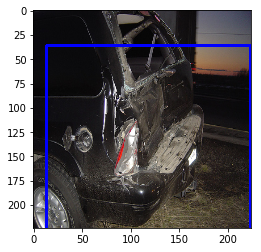

In [142]:
img_str = img_path + img_file
img = display.read_img(img_str, target_size)

img = display.draw_boxes(img, bb_hat)
#img = display.draw_text(img, ids, bb_hat)
plt.imshow(img)
plt.show()